In [47]:
# Imports
import os
import time
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms, models

In [41]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for AlexNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10('../data', download=True, train=True, transform=train_transform)
test_dataset = datasets.CIFAR10('../data', train=False, download=True, transform=test_transform)

train_data, val_data = torch.utils.data.random_split(train_dataset, [40000, 10000])

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Alexnet

In [4]:
class AlexNet(nn.Module):
    def __init__(self, n_classes: int = 10):
        super(AlexNet, self).__init__()

        self.feature_extractors = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, n_classes)
        )

    def forward(self, x):
        x = self.feature_extractors(x)
        x = self.adaptive_pool(x)
        x = self.classification(x)

        return x


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

alexnet = AlexNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

cuda


In [4]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    before = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-"*10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for imgs, labels in dataloader[phase]:
                imgs, labels = imgs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    if is_inception and phase == "train":
                        outputs, aux1, aux2 = model(imgs, train=True)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux1, labels)
                        loss3 = criterion(aux2, labels)
                        loss = loss1 + 0.3 * loss2 + 0.3 * loss3
                    else:
                        outputs = model(imgs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1) # _ - max values, and preds - indices -> classes
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * imgs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset)
            
            elapsed_epoch = time.time() - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + '.pth')
            
            if phase == 'val':
                val_acc_history.append(epoch_acc.item())
            
            if phase == 'train':
                loss_acc_history.append(epoch_loss)
        
        print()

    time_elapsed = time.time() - before
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

def test_model(model, dataloader, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    before = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-"*10)

        
        model.eval()

            running_loss = 0.0
            running_corrects = 0

            for imgs, labels in dataloader[phase]:
                imgs, labels = imgs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    if is_inception and phase == "train":
                        outputs, aux1, aux2 = model(imgs, train=True)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux1, labels)
                        loss3 = criterion(aux2, labels)
                        loss = loss1 + 0.3 * loss2 + 0.3 * loss3
                    else:
                        outputs = model(imgs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1) # _ - max values, and preds - indices -> classes
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * imgs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset)
            
            elapsed_epoch = time.time() - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + '.pth')
            
            if phase == 'val':
                val_acc_history.append(epoch_acc.item())
            
            if phase == 'train':
                loss_acc_history.append(epoch_loss)
        
        print()

    time_elapsed = time.time() - before
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

In [7]:
dataloaders = { 'train': train_dataloader, 'val': val_dataloader }

best_model, val_acc_history, loss_acc_history = train_model(alexnet, dataloaders, criterion, optimizer, 10, "alex_module_lr_0.001_best")

Epoch 0/9
----------
train Loss: 2.0135 Acc: 0.2407
Epoch time taken:  45.38444709777832
val Loss: 1.5777 Acc: 0.4127
Epoch time taken:  56.587465047836304

Epoch 1/9
----------
train Loss: 1.5045 Acc: 0.4480
Epoch time taken:  46.45918655395508
val Loss: 1.3588 Acc: 0.5123
Epoch time taken:  58.114521741867065

Epoch 2/9
----------
train Loss: 1.2674 Acc: 0.5418
Epoch time taken:  46.46684455871582
val Loss: 1.1886 Acc: 0.5846
Epoch time taken:  58.427972078323364

Epoch 3/9
----------
train Loss: 1.0672 Acc: 0.6230
Epoch time taken:  45.707512855529785
val Loss: 0.9426 Acc: 0.6617
Epoch time taken:  56.95591640472412

Epoch 4/9
----------
train Loss: 0.8980 Acc: 0.6823
Epoch time taken:  45.81937289237976
val Loss: 0.8689 Acc: 0.6925
Epoch time taken:  57.10862588882446

Epoch 5/9
----------
train Loss: 0.7840 Acc: 0.7263
Epoch time taken:  45.236807107925415
val Loss: 0.7904 Acc: 0.7244
Epoch time taken:  57.10383439064026

Epoch 6/9
----------
train Loss: 0.6890 Acc: 0.7583
Epoch t

In [8]:
import matplotlib.pyplot as plt

def plot_data(val_acc_history, loss_acc_history):
    plt.plot(loss_acc_history, label = 'Validation')
    plt.title('Loss per epoch')
    plt.legend()
    plt.show()
    plt.plot(val_acc_history, label = 'Validation')
    plt.title('Accuracy per epoch')
    plt.legend()
    plt.show()

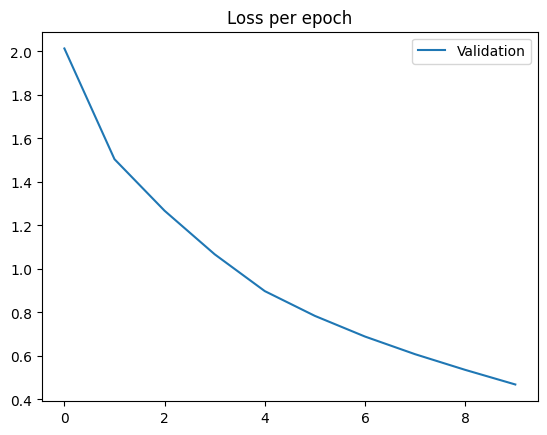

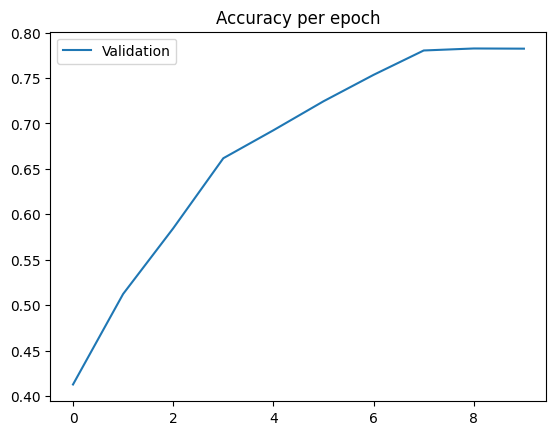

In [9]:
plot_data(val_acc_history, loss_acc_history)

In [10]:
from torchsummary import summary

summary(alexnet, input_size=(3, 224, 224))

ModuleNotFoundError: No module named 'torchsummary'

### GoogleNet

In [82]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        # red -> reduce
        super(Inception, self).__init__()

        self.in_planes      = in_planes
        self.n1x1           = n1x1
        self.n3x3red        = n3x3red
        self.n3x3           = n3x3
        self.n5x5red        = n5x5red
        self.n5x5           = n5x5
        self.pool_planes    = pool_planes

        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(inplace=True),

            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True),
        )

        # 1x1 conv -> 5x5 conv branch
        # Inceptionv1, it uses 5x5 conv (keeping same logic as per assignment base)
        # but if we want to replicate the paper carefully -> we would need to replace it
        # omitting and using two 3x3 conv (which was formulated in Inceptionv2 paper)
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(inplace=True),

            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True),

            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True),
        )
        
        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)

        return torch.cat([y1, y2, y3, y4], dim=1)


In [84]:
class GoogleNet(nn.Module):
    def __init__(self, n_classes: int = 1000):
        super(GoogleNet, self).__init__()

        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)

        # auxilary classifier 1
        self.aux1_avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.aux1_conv = nn.Conv2d(512, 128, kernel_size=1, stride=1)
        self.aux1_bn = nn.BatchNorm2d(128)
        self.aux1_fc1 = nn.Linear(4 * 4 * 128, 1024)
        self.aux1_dropout = nn.Dropout(p=0.7) # 70% ratio
        self.aux1_fc2 = nn.Linear(1024, n_classes)

        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)

        # auxilary classifier 2
        self.aux2_avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.aux2_conv = nn.Conv2d(528, 128, kernel_size=1, stride=1)
        self.aux2_bn = nn.BatchNorm2d(128)
        self.aux2_fc1 = nn.Linear(4 * 4 * 128, 1024)
        self.aux2_dropout = nn.Dropout(p=0.7) # 70% ratio
        self.aux2_fc2 = nn.Linear(1024, n_classes)

        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.linear  = nn.Linear(1024, n_classes)

    
    def forward(self, x, train=False):
        aux1, aux2 = 0, 0
        
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)

        if train:
            aux1 = self.aux1_avgpool(out)
            aux1 = F.relu(self.aux1_bn(self.aux1_conv(aux1)))
            aux1 = torch.flatten(aux1, 1)
            aux1 = self.aux1_dropout(F.relu(self.aux1_fc1(aux1)))
            aux1 = self.aux1_fc2(aux1)            

        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)

        if train:
            aux2 = self.aux2_avgpool(out)
            aux2 = F.relu(self.aux2_bn(self.aux2_conv(aux2)))
            aux2 = torch.flatten(aux2, 1)
            aux2 = self.aux2_dropout(F.relu(self.aux2_fc1(aux2)))
            aux2 = self.aux2_fc2(aux2)

        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)

        if train:
            return out, aux1, aux2

        return out


In [7]:
googlenet = GoogleNet(n_classes=10).to(device)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(googlenet.parameters(), momentum=0.9, lr=0.001)

In [8]:
dataloaders = { 'train': train_dataloader, 'val': val_dataloader }

best_model2, val_acc_history2, loss_acc_history2 = train_model(googlenet, dataloaders, criterion2, optimizer2, 15, "googlenet_module_lr_0.001_best", is_inception=True)

Epoch 0/14
----------
train Loss: 2.4234 Acc: 0.4574
Epoch time taken:  172.69162821769714
val Loss: 1.0698 Acc: 0.6113
Epoch time taken:  183.46275758743286

Epoch 1/14
----------
train Loss: 1.6325 Acc: 0.6568
Epoch time taken:  183.61280632019043
val Loss: 0.7921 Acc: 0.7247
Epoch time taken:  195.3561086654663

Epoch 2/14
----------
train Loss: 1.2436 Acc: 0.7496
Epoch time taken:  182.33090734481812
val Loss: 0.6466 Acc: 0.7769
Epoch time taken:  193.7907247543335

Epoch 3/14
----------
train Loss: 1.0081 Acc: 0.8036
Epoch time taken:  184.68632078170776
val Loss: 0.6049 Acc: 0.7924
Epoch time taken:  195.99578499794006

Epoch 4/14
----------
train Loss: 0.8500 Acc: 0.8391
Epoch time taken:  178.20713710784912
val Loss: 0.5122 Acc: 0.8266
Epoch time taken:  188.99292850494385

Epoch 5/14
----------
train Loss: 0.7223 Acc: 0.8676
Epoch time taken:  181.87393379211426
val Loss: 0.5775 Acc: 0.8083
Epoch time taken:  193.4015302658081

Epoch 6/14
----------
train Loss: 0.6113 Acc: 0.8

In [11]:
!python main.py

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/9
----------
train Loss: 2.2641 Acc: 0.1323
Epoch time taken:  51.62145519256592
val Loss: 2.0536 Acc: 0.2422
Epoch time taken:  62.22923135757446

Epoch 1/9
----------
train Loss: 1.8374 Acc: 0.3173
Epoch time taken:  51.751463651657104
val Loss: 1.5916 Acc: 0.4099
Epoch time taken:  61.78646755218506

Epoch 2/9
----------
train Loss: 1.4905 Acc: 0.4525
Epoch time taken:  51.90189504623413
val Loss: 1.3701 Acc: 0.5012
Epoch time taken:  62.61916399002075

Epoch 3/9
----------
train Loss: 1.3018 Acc: 0.5260
Epoch time taken:  51.57613921165466
val Loss: 1.2488 Acc: 0.5496
Epoch time taken:  62.414655923843384

Epoch 4/9
----------
train Loss: 1.1465 Acc: 0.5909
Epoch time taken:  51.91716265678406
val Loss: 1.0747 Acc: 0.6149
Epoch time taken:  62.40043020248413

Epoch 5/9
----------
train Loss: 0.9963 Acc: 0.6480
Epoch time taken:  51.65522599220276
val Loss: 0.8993 Acc: 0.6814
Epoch time taken:  62.81

In [76]:
from architecture.custom_layers import LocalResponseNormalize

class AlexNet(nn.Module):
    def __init__(self, n_classes: int = 10):
        super(AlexNet, self).__init__()

        self.feature_extractors = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            LocalResponseNormalize(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            LocalResponseNormalize(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, n_classes)
        )

    def forward(self, x):
        x = self.feature_extractors(x)
        x = self.adaptive_pool(x)
        x = self.classification(x)

        return x


In [77]:
alx = AlexNet().to(device)

params = torch.load('main_alex_module_lr_0.001_best.pth')

alx.load_state_dict(params)

test_model(alx, test_dataloader, device)

# from summary import summary_string
# model_summary, _ = summary_string(alx, input_size=(3, 224, 224))
    
# with open('alexnet_summary.txt', 'w') as f:
#     f.write(str(model_summary))

/tmp/ipykernel_994233/2959433572.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  params = torch.load('main_alex_module_lr_0.001_best.pth')


Accuracy on the CIFAR-10 test set: 53.60%


In [85]:
googlenet = GoogleNet(n_classes=10).to(device)

params = torch.load('main_googlenet_module_lr_0.001_best.pth')

googlenet.load_state_dict(params)

test_model(googlenet, test_dataloader, device)

/tmp/ipykernel_994233/1979083515.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  params = torch.load('main_googlenet_module_lr_0.001_best.pth')


Accuracy on the CIFAR-10 test set: 71.19%


In [71]:
def test_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Accuracy on the CIFAR-10 test set: {accuracy:.2f}%")

# classification_models = torchvision.models.list_models(module=torchvision.models)

In [78]:
from torchvision.models import alexnet, googlenet
import numpy as np

device = torch.device("cuda:0")

model_alexnet = alexnet(pretrained=True)
model_alexnet.classifier[6] = nn.Linear(4096, 10)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params': model_alexnet.features.parameters(), 'lr': 0.0001},
    {'params': model_alexnet.classifier.parameters(), 'lr': 0.001}
])

model_alexnet = model_alexnet.to(device)

epochs = 3
print("TRAIN")
for epoch in range(epochs):
    model_alexnet.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model_alexnet(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader):.4f}")

test_model(model_alexnet, test_dataloader, device)

# gnet = googlenet(pretrained=True).to(device)
# gnet.fc = nn.Linear(1024, 10)

# test_model(gnet, test_dataloader, device)

TRAIN
Epoch [1/3], Loss: 0.9054
Epoch [2/3], Loss: 0.6230
Epoch [3/3], Loss: 0.4961
Accuracy on the CIFAR-10 test set: 67.80%


In [79]:
model_googlenet = googlenet(pretrained=True, aux_logits=True)

model_googlenet.fc = nn.Linear(1024, 10)

if model_googlenet.aux_logits:
    model_googlenet.aux1.fc2 = nn.Linear(1024, 10)
    model_googlenet.aux2.fc2 = nn.Linear(1024, 10)
model_googlenet = model_googlenet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params': model_googlenet.parameters(), 'lr': 0.001}, 
])

epochs = 3
for epoch in range(epochs):
    model_googlenet.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs, aux1, aux2 = model_googlenet(images)
        loss_main = criterion(outputs, labels)
        loss_aux1 = criterion(aux1, labels)
        loss_aux2 = criterion(aux2, labels)
        
        loss = loss_main + 0.3 * (loss_aux1 + loss_aux2)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader):.4f}")


test_model(model_googlenet, test_dataloader, device)

Epoch [1/3], Loss: 1.4780
Epoch [2/3], Loss: 0.9664
Epoch [3/3], Loss: 0.7703
Accuracy on the CIFAR-10 test set: 74.42%


## Exercises

1. Create these three networks. Be sure to properly define your Python classes, with one class per file and a main module that sets up your
   objects, runs the training process, and saves the necessary data. - done
3. Note that the AlexNet implementation here does not have the local response normalization feature described in the paper. Take a look at the
   [PyTorch implementation of LRN](https://pytorch.org/docs/stable/generated/torch.nn.LocalResponseNorm.html) and incorporate it into your AlexNet implementation as
   it is described in the paper. Compare your test set results with and without LRN.
4. Note that the backbone of the GoogLeNet implemented thus far does not correspond exactly to the description. Modify the architecture to
   1. Use the same backbone (input image size, convolutions, etc.) before the first Inception module
   2. Add the two side classifiers
5. Compare your GoogLeNet and AlexNet implementations on CIFAR-10. Comment on the number of parameters, speed of training, and accuracy of the two models on this dataset when
   trained from scratch.
6. Experiment with the pretrained GoogLeNet and AlexNet from the torchvision repository. Does it give better results on CIFAR-10 similar to what we found with AlexNet? Comment
   on what we can glean from the results about the capacity and generalization ability of these two models.

## The report
1. I created each network in the folder architecture - to run training - python main.py

| Models | Epochs | Number of Params | Training time | Accuracy (validation set) | Accuracy (test set) |
|--------|--|----------------|---------------|----------|-----------|
| AlexNet|  10 | 58,322,314    |   10m 1s      |  0.782500| 0.512 |
| AlexNet with LRN | 10 |58,322,314 | 10m 58s  |  0.752600 | 0.536 |
| GoogleNet with AUX CLASS | 10 | 6,281,258 | 48m 16s | 0.865500 | 0.7119 |
| AlexNet (from torchvision) | 3 | 58,322,314    |   -      |  - | 0.678 |
| GoogleNet (from torchvision) | 3 | 6,281,258   |   -      |  - | 0.7442 |

